# WHETGEO-2D

## Srivastava and Yeh 1991 - layered soil wetting case.

    -Authors: Niccolò Tubini, Riccardo Rigon
    - Licence: this work is licensed under a Creative Commons Attribution-NonCommercial 4.0 International License
-----

**This notebook is freely inspired to the Notebooks presented in Clark et al. (2021)**

## Table of Contents

* [Expectations](#Expectations)
* [Meta data](#Meta-data)
* [Reference](#Reference)
* [Computational grid](#Computational-grid)
* [Visualize the output](#Visualize-the-output)
    * [Saturation degree](#Saturation-degree)




## Expectations
The simulation should reproduce the analytical solution presented in Srivastava and Yeh (1991) for layered soil under wetting condition. 

Soil parameters are:
- $\alpha = 0.1$,
- $\theta_{s1}=\theta_{s2}=0.4$, 
- $\theta_{r1}=\theta_{r2}=0.06$,
- $K_{s1}=10$ [cm/h], 
- $K_{s2}=1$ [cm/h].

<figure>
    <center>
    <img src="Figures/Srivastava_Yeh_1991_layered_wetting_set_1b.PNG" width="400" height="400/1.618">
    <figcaption>Figure (7) in Srivastava and Yeh (1991). </figcaption>
    </center>
</figure>

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| WHETGEO-2D |
| Model version  |  v0.9-beta |
| Model reference | Tubini and Rigon (2022) |
| Grid input file | `data/mesh/Srivastatva_Yeh_1991/Srivastava_Yeh_1991_layered.csv|
| Boundary condition file | `data/Timeseries/Srivastatva_Yeh_1991/Srivastava_Yeh_1991_wetting.csv` |
| Initial condition file | `data/mesh/Srivastatva_Yeh_1991/Srivastava_Yeh_1991_psi_0_layered_wetting_set1b.csv` |
| .sim file | `simulation/WHETGEO2D_Srivastava_Yeh_1991_layered_wetting_set_1b.sim` |
| Model runs by | N. Tubini|
| Notebook code by | N. Tubini | 

## Reference

- Clark, M.P., Zolfaghari, R., Green, K.R., Trim, S.J., Knoben, W.J., Bennett, A.R., Nijssen, B., Ireson, A.M., & Spiteri, R.J. (2021). The numerical implementation of land models: Problem formulation and laugh tests. Journal of Hydrometeorology.

- Srivastava, R., & Yeh, T. C. J. (1991). Analytical solutions for one‐dimensional, transient infiltration toward the water table in homogeneous and layered soils. Water Resources Research, 27(5), 753-762.

- Tubini, N.: Theoretical and numerical tools for studying the Critical Zone from plot to catchments, PhD thesis, University of Trento, 2021.

In [8]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as cl # to define new color map


import whetgeo2d_mesh 

from matplotlib import rc
%matplotlib inline
import matplotlib.style as style 
import matplotlib.tri as tri
import math
import xarray as xr


from srivastava_yeh_1991_analytical_solution import *

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.4,
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 16,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

plt.rcParams.update(nice_fonts)


linewidth_n = 0.8
linewidth_a = 0.9
color_map = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']

# my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",['#f1eef6', '#bdc9e1', '#74a9cf', '#2b8cbe', '#045a8d'])



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
project_path = os.path.dirname(os.getcwd())

## Discretize the domain

- **x_left**: x coordinate of the left border;
- **x_right**: x coordinate of the right border;
- **z_top**: z coordinate of the top boundary defined with respect to the bottom
- **IMAX**: number of cells in the x-direction
- **KMAX**: number of cells in the z-direction
- **regions_xlim**: x coordinate limits of subdomains
- **regions_zlim**: z coordinate limits of subdomains
- **labels**: labels of subdomains
- **bottom_bc_label**: bottom boundary condition label
- **right_bc_label**: right boundary condition label
- **left_bc_label**: left boundary condition label
- **top_bc_label**: top boundary condition label
- **file_name**: file name containing the grid

More details can be found in the documentation of the function `whetgeo2D_mesh.create_structured_mesh`.

In [10]:
x_left = 0
x_right = 0.5

z_top = 2 

IMAX = 5
KMAX = 2000

regions_xlim = [ [0,0.5], [0,0.5]]
regions_zlim = [ [0,1], [1,2]]

labels = [0,1]

bottom_bc_label = 20
right_bc_label = 10
left_bc_label = 10
top_bc_label = 11

file_name = project_path+'/data/mesh/Srivastatva_Yeh_1991/Srivastava_Yeh_1991_layered.csv'
whetgeo2d_mesh.create_structured_mesh(x_left, x_right, z_top, IMAX, KMAX, regions_xlim, regions_zlim, labels, bottom_bc_label, right_bc_label, left_bc_label, top_bc_label, file_name)

## Initial condition

The initial condition is determined by imposing as lower boundary condition $\psi = 0$ [m] and a constant water flux at the soil surface $q_A = 2.78  10^{-7}$ [ms$^{-1}$].

In [11]:
L1 = 100 # cm
L2 = 100
Ks1 = 10
Ks2 = 1
alpha1 = 0.1
alpha2 = 0.1
theta_s1 = 0.4
theta_r1 = 0.06
theta_s2 = 0.4
theta_r2 = 0.06
qA1 = 0.1
qA2 = 0.1
qB1 = 0.9
qB2 = 0.9

psi_bottom = 0


[quad, nodes, x_c, z_c, ID] = whetgeo2d_mesh.reconstruct_structured_csv(file_name, IMAX, KMAX)
file_name_ic = project_path+'/data/mesh/Srivastatva_Yeh_1991/Srivastava_Yeh_1991_psi_0_layered_wetting_set1b.csv'
psi_0 = initial_condition_layered_soil(L1, L2, (z_c[:]-2)*100+L1, Ks1, Ks2, alpha1, alpha2, theta_s1, theta_r1, theta_s2, theta_r2, qA1, qB1, qA2, qB2, psi_bottom, file_name_ic)


# Output

In [14]:
ds = xr.open_dataset(project_path+"/output/Srivastava_Yeh_1991_layered_wetting_set1b_0000.nc")


## Compute the analytical solution

In [13]:
times = np.array([0.1,0.5,1,2,3,10,15,20,30,40,50,100])
z = z_c.reshape((KMAX, IMAX))
[psi_00, theta_00, psi, theta] = solution_layered_soil(L1, L2, (z[:,0]-2)*100+L1, Ks1, Ks2, alpha1, alpha2, theta_s1, theta_r1, theta_s2, theta_r2, qA1, qB1, qA2, qB2, psi_bottom, times)

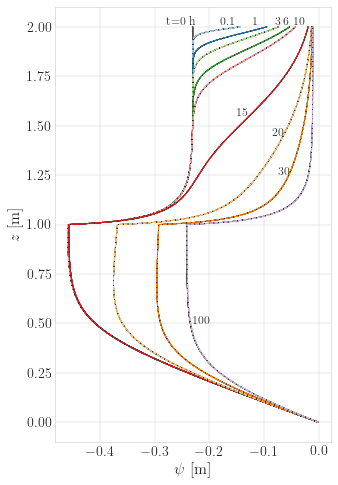

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8/1.618, 8)) 
plt.plot(np.nan,np.nan, linewidth=linewidth_n, color='0.1', label='Numerical sol.')
plt.plot(np.nan,np.nan, linewidth=linewidth_n, linestyle='--', color='0.2', label='Analytical sol.')

plt.plot(psi_00*1e-2, z, linewidth=linewidth_a, color='0.3')

plt.plot(ds.psi.values[5,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[0.1]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[0])

plt.plot(ds.psi.values[29,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[0.5]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[1])

plt.plot(ds.psi.values[1*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[1]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[2])

plt.plot(ds.psi.values[2*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[2]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[3])

plt.plot(ds.psi.values[3*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[3]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[4])

plt.plot(ds.psi.values[10*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[10]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[5])

plt.plot(ds.psi.values[20*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[20]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[6])

plt.plot(ds.psi.values[30*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[30]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[7])

plt.plot(ds.psi.values[100*60-1,:].reshape((KMAX,IMAX))[:,3], z, linewidth=linewidth_n, color='0.2')
plt.plot(psi[100]/100, z,   linestyle='--', linewidth=linewidth_a, color=color_map[8])

plt.annotate('t=0 h', (-0.28,2.01), xycoords='data', fontsize=12)
plt.annotate('0.1', (-0.18,2.01), xycoords='data', fontsize=12)
plt.annotate('1', (-0.12,2.01), xycoords='data', fontsize=12)
plt.annotate('3', (-0.08,2.01), xycoords='data', fontsize=12)
plt.annotate('6', (-0.065,2.01), xycoords='data', fontsize=12)
plt.annotate('10', (-0.045,2.01), xycoords='data', fontsize=12)
plt.annotate('15', (-0.15,1.55), xycoords='data', fontsize=12)
plt.annotate('20', (-0.085,1.45), xycoords='data', fontsize=12)
plt.annotate('30', (-0.075,1.25), xycoords='data', fontsize=12)
plt.annotate('100', (-0.23,0.5), xycoords='data', fontsize=12)

plt.xlabel('$\psi$ [m]')
plt.ylabel('$z$ [m]')
plt.show()
# fig.savefig('SrivastaveYeh_homogeneous_drainage_set1.pdf', dpi=300, bbox_inches='tight')